Metoda 1. Generowanie 100 punktów z przedziału [-100,100] 

In [2]:
from random import uniform, randint
import matplotlib.pyplot as plt
import numpy as np
from time import time
import math
import copy
from IPython import display

In [5]:
def det(a,b,c):
    return (b[0]*c[1]-c[0]*b[1])-(a[0]*c[1]-a[1]*c[0])+(a[0]*b[1]-b[0]*a[1])

In [6]:
def First_generator(n=100):
    return [ (uniform(-100,100),uniform(-100,100)) for _ in range(n) ]

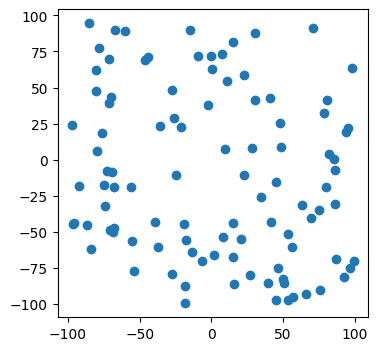

In [7]:
points1 = First_generator()
plt.figure(figsize=(4,4))
plt.scatter(*zip(*points1))
# plt.show()
plt.savefig("100_from_100_to_100.png")

Metoda 2. Okrąg o promieniu 10 i centrum (0,0)

In [8]:
def Second_generator(n=100):
    result = [ ]
    for _ in range(n):
        theta = uniform(0,2*np.pi)
        R = 10
        result.append((R*np.cos(theta),R*np.sin(theta)))
    return result

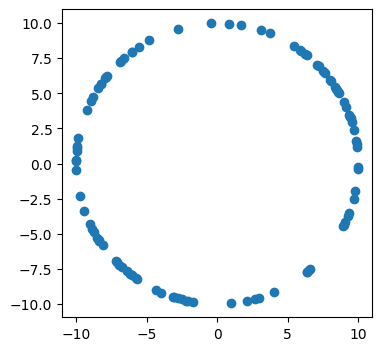

In [9]:
points2 = Second_generator()
plt.figure(figsize=(4,4))
plt.scatter(*zip(*points2))
plt.savefig("Circle_of_radius_10_center_0,0.png")

Generator 3. Boki prostokąta 

In [10]:
def Third_generator(n=100):
    result = []
    for _ in range(n):
        x = uniform(-10,10)
        if randint(0,2) % 2 == 0: 
            result.append((x,10*((-1)**randint(0,1))))
        else:
            result.append((10*((-1)**randint(0,1)),x))

    return result

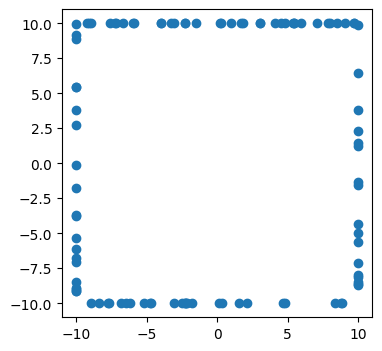

In [11]:
points3 = Third_generator()
plt.figure(figsize=(4,4))
plt.scatter(*zip(*points3))
# plt.show()
plt.savefig("10x10_square.png")

In [12]:
def Fourth_generator():
    result = [(0,0),(10,0),(0,10),(10,10)]
    for _ in range(25):
        x = uniform(0,10)
        if randint(0,2) % 2 == 0: 
            result.append((x,0))
        else:
            result.append((0,x))
    for _ in range(20):
        x = uniform(0,10)
        orientation = randint(0,1)
        result.append((x,10*orientation+x*(-1)**orientation))
    return result

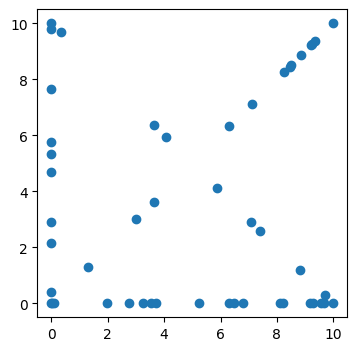

In [13]:
points4 = Fourth_generator()
plt.figure(figsize=(4,4))
plt.scatter(*zip(*points4))
plt.savefig("4_corners_OX_OY_diagonal.png")

In [14]:
def create_tex_table(table_name,data):
    
    latex_template = r"""
\begin{table}[H]
    \renewcommand{\tablename}{Tabela}

    \centering
    \small
    \caption{Tabela różnic czasów obliczeń i tolerancji dla generatora Linia $(x, y) = v \cdot t$, $v = (0, 0.1)$, $t \in \mathbb{R}$}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{@{}lllc@{}}
        \toprule
        Nazwa zboiru & Czas obliczeń dla algorytmu Grahama (ms) &  Czas obliczeń dla algorytmu Jarvisa (ms) 
        \\ \midrule
"""
    
    for row in data:
        latex_template += f"        {row['Name']} & {row['Graham']} & {row['Jarvis']} \\\\ \n"

    latex_template += r"""        \bottomrule
    \end{tabular}
}
    \label{table:generator4}
    \small
    \normalsize
\end{table}
"""

    output_filename = f"{table_name}.tex"
    with open(output_filename, "w") as f:
        f.write(latex_template)

    print(f"LaTeX table has been written to {output_filename}")


Implementacja alorytmu Grahama

In [12]:
def show_dump_hull(points,hull,name,adder):
    plt.figure(figsize=(4,4))
    plt.scatter(*zip(*points))
    n = len(hull)
    with open(name + adder + ".txt",'w') as f:
        for i in range(n):
            print(f"From: {hull[i]} to {hull[(i+1)%n]}")
            x_values = [hull[i][0], hull[(i+1) % n][0]]
            y_values = [hull[i][1], hull[(i+1) % n][1]]
            
            # Plot a line between the current point and the next
            plt.plot(x_values, y_values, 'r-')
        plt.show()


In [20]:
E = 1e-10
frame_count = 0
generator = 0

def merge(L, R):
    new = []
    i = j = 0
    while i < len(L) and j < len(R):
        if det((0,0),L[i],R[j]) < 0:
            new.append(L[i])
            i += 1
        else:
            new.append(R[j])
            j += 1
    new.extend(L[i:])
    new.extend(R[j:])
    return new

def radial_sort(points):
    if len(points) < 2:
        return points
    mid = len(points) // 2
    left = radial_sort(points[:mid])
    right = radial_sort(points[mid:])
    return merge(left, right)

def point_generator(n=20,x_max=100,x_min=-100,y_max=100,y_min=-100):
    return [ (uniform(x_min,x_max),uniform(y_min,y_max)) for _ in range(n) ] 

def det2x2(a,b,c):
    return ((a[0]-c[0])*(b[1]-c[1]))-((b[0]-c[0])*(a[1]-c[1]))

In [13]:

def Graham_visualized(points,det_fun=det2x2):
    global frame_count
    global generator
    frame_count = 0
    result = []
    points = sorted(points, key=lambda p: (p[1], p[0])) 
    starting_point = points[0]
    sorted_points = sorted(points[1:], key=lambda p: math.atan2(p[1] - starting_point[1], p[0] - starting_point[0]))
    fig, ax = plt.subplots()
    ax.set_aspect('equal','box')
    # ax.set_xlim(x_min,x_max)
    # ax.set_ylim(y_min_y_max)
    for point in points:
        ax.plot(*point, 'bo')
    print("Sorting points")
    points = radial_sort(points)
    print(points)
    # Start building the convex hull
    result = [starting_point, sorted_points[0]]
    ax.plot(*starting_point,'go')
    ax.plot(*sorted_points[0],'go')   
    first_line, = ax.plot([starting_point[0], sorted_points[0][0]],[starting_point[1],sorted_points[0][1]],'b-')
    lines_stack = [first_line]
    print("Creating hull")
    previous_point = starting_point 
    for i, point in enumerate(sorted_points[1:]):
        ax.plot(*point, 'ro')
        display.clear_output(wait=True)
        display.display(fig)
        plt.draw()
        plt.pause(0.01)
        # plt.savefig(f"Graham_{generator}_{frame_count}.png")
        frame_count += 1
        d = det_fun(result[-2], result[-1], point)
        while len(result) > 1 and (d < -E or (d > -E and d < E)):
            display.clear_output(wait=True)
            display.display(fig)
            plt.draw()
            plt.pause(0.01)
            # plt.savefig(f"Graham_{generator}_{frame_count}.png")
            frame_count += 1
            lines_stack[-1].remove()
            lines_stack.pop()
            ax.plot(*result[-1],'ko') 
            result.pop()
            if len(result) <= 1:
                break
            d = det_fun(result[-2], result[-1], point)
        line, = ax.plot([point[0], result[-1][0]], [point[1], result[-1][1]],'b-')
        lines_stack.append(line)
        result.append(point)
        ax.plot(*point,'go')
        display.clear_output(wait=True)
        display.display(fig)
        plt.draw()
        plt.pause(0.01)
        frame_count += 1
    line, = ax.plot([result[-1][0], result[0][0]], [result[-1][1], result[0][1]],'b-')
    ax.plot(*result[-1], 'go')
    plt.draw()
    plt.savefig(f"Graham_{generator}.png")
    # display.clear_output(wait=True)
    # display.display(fig)
    # plt.pause(0.2)
    return result

points_set = [(points1,"Gen1"),(points2,"Gen2"),(points3,"Gen3"),(points4,"Gen4")]

adder="_Graham"

for points, fname in points_set:
    generator += 1
    hull = Graham_visualized(points)
    with open(fname+adder+"_ans.txt","w") as f:
        f.write(str(hull))
    show_dump_hull(points,hull,fname,adder)

KeyboardInterrupt: 

Implementacja algorytmu Jarvisa

In [27]:
def squared_distance(a, b):
    return (a[0] - b[0])**2 + (a[1] - b[1])**2

E = 1e-10
frame_count = 0

In [26]:
def follows(prev, current, next,det_fun=det):
    d = det_fun(prev, current, next)
    if d < -E:
        return True  
    if d > E:
        return False
    return squared_distance(prev, current) < squared_distance(prev, next)

def choose_next(points, last, current, fig, ax,det_fun=det):
    act = current
    prevline = None
    for point in points:
        if act == last or follows(last, act, point,det_fun=det_fun):
            if act != current:
                ax.plot(*act, 'bo') 
            line, = ax.plot([last[0], act[0]], [last[1], act[1]],'b-')
            if prevline is not None:
                prevline.remove()
            prevline = line
            act = point
            ax.plot(*point, 'ro')
            display.clear_output(wait=True)
            display.display(fig)
            plt.draw()
            plt.pause(0.02)
    if prevline is not None:
        prevline.remove()
    return act

def Jarvis(points,det_fun=det):
    points_set = copy.deepcopy(points)
    fig, ax = plt.subplots()
    ax.set_aspect('equal','box')
    for point in points:
        ax.plot(*point, 'bo')
    start = min(points_set, key=lambda x: (x[1], x[0]))  
    hull = [start]
    
    current_point = start
    
    while True:
        next_point = choose_next(points_set, hull[-1], current_point, fig, ax,det_fun=det_fun)
        ax.plot(*next_point, 'ko')
        display.clear_output(wait=True)
        display.display(fig)
        plt.draw()
        plt.pause(0.2)
        if next_point == start:
            ax.plot(*next_point,'go')
            break  # Completed the hull
        line, = ax.plot([next_point[0], hull[-1][0]], [next_point[1], hull[-1][1]],'b-')
        hull.append(next_point)
        current_point = next_point
        ax.plot(*next_point, 'go')
        display.clear_output(wait=True)
        display.display(fig)
        plt.draw()
        plt.pause(0.2)
    line, = ax.plot([next_point[0], hull[-1][0]], [next_point[1], hull[-1][1]],'b-')
    hull.append(next_point)
    current_point = next_point
    ax.plot(*next_point, 'go')
    display.clear_output(wait=True)
    display.display(fig)
    plt.draw()
    plt.pause(0.2)
    return hull

# Define multiple point sets for testing
points_set = [points1,points2,points3,points4]
adder = "Jarvis"
# Calculate and plot hulls for each point set
for points in points_set:
    hull = Jarvis(points)
    # hull, time = Jarvis_timed(points)
    
    show_dump_hull(points, hull, name=fname, adder=adder)


KeyboardInterrupt: 

In [24]:


def Graham_timed(points,det_fun=det):
    result = []
    points = sorted(points, key=lambda p: (p[1], p[0])) 
    starting_point = points[0]
    sorted_points = sorted(points[1:], key=lambda p: math.atan2(p[1] - starting_point[1], p[0] - starting_point[0]))
    print("Sorting points")
    points = radial_sort(points)
    result = [starting_point, sorted_points[0]]
    print("Creating hull")
    start = time()
    previous_point = starting_point 
    for i, point in enumerate(sorted_points[1:]):
        d = det_fun(result[-2], result[-1], point)
        while len(result) > 1 and d < -E or (d > -E and d < E):
            result.pop()
            if len(result) <= 1:
                break
            d = det_fun(result[-2], result[-1], point)
        result.append(point)
    finish = time()

    print(f"Finished after {finish - start} seconds")
    runtime = finish - start
    print(result)
    return result, runtime


def follows(prev, current, next,det_fun=det):
    d = det_fun(prev, current, next)
    if d < -E:
        return True  
    if d > E:
        return False
    return squared_distance(prev, current) < squared_distance(prev, next)


def choose_next_time(points, last, current, det_fun=det):
    act = current
    for point in points:
        if act == last or follows(last, act, point,det_fun=det_fun):
            act = point
    return act

def Jarvis_timed(points,det_fun=det):
    points_set = copy.deepcopy(points)
    print("Starting Jarvis")
    start = time()
    startPoint = min(points_set, key=lambda x: (x[1], x[0]))  
    current_point = startPoint
    hull = [startPoint]        
    while True:
        next_point = choose_next_time(points_set, hull[-1], current_point,det_fun=det_fun)
        if next_point == startPoint:
            break  # Completed the hull
        hull.append(next_point)
        current_point = next_point
    finish = time()
    runtime = finish - start
    return hull, runtime




In [25]:
# Define multiple point sets for testing
points_set = [(points1,"Pierwszy"),(points2,"Drugi"),(points3,"Trzeci"),(points4,"Czwarty")]
data = []


for points, name in points_set:

    Graham_hull, time_g = Graham_timed(points)
    Jarvis_hull, time_j = Jarvis_timed(points)
    data.append({"Name":name , "Graham":time_g*1000, "Jarvis":time_j*1000})
    create_tex_table("Wyniki",data) 

Sorting points
Creating hull
Finished after 0.0003094673156738281 seconds
[(-18.046958269266767, -99.47507082444591), (53.47712660092475, -97.36966227141228), (75.62224558820577, -90.44496428188877), (92.7375299831858, -81.44899247191228), (97.05380657808968, -74.75376983955478), (99.26231182600088, -70.4545818549559), (98.15346128792865, 63.81105657164437), (70.74418380084722, 91.19530177347465), (-85.69494417659948, 94.52325421925352), (-97.3457872656458, 23.856333049561258), (-96.38058913480702, -44.3547942713046), (-83.94091567084524, -62.20795559722354)]
Starting Jarvis


NameError: name 'squared_distance' is not defined

In [17]:
def csv_dump(table_name,data):
    
    content = "Ilość punktów dla zbioru; Czas obliczeń dla algorytmu Grahama (ms);Czas obliczeń dla algorytmu Jarvisa (ms);Punkty na otoczce\n"
    
    def wrap(number):
        return str(round(number,2)).replace('.',',')
    for row in data:
        value_G = row['Graham']
        value_J = row['Jarvis']
        unit_G = 'ms'
        unit_J = 'ms'
        if int(row['Graham']) >= 1000:
            unit_G = 's'
            value_G /= 1000
        if int(row['Jarvis']) >= 1000:
            unit_J = 's'
            value_J /= 1000
        graham_time = wrap(value_G) + unit_G
        jarvis_time = wrap(value_J) + unit_J
        content = content + f"{row['Name']};{graham_time};{jarvis_time};{row['Points']}\n"
    output_filename = f"{table_name}.csv"
    with open(output_filename, "w") as f:
        f.write(content)

    print(f"CSV data table has been written to {output_filename}")

def create_tex_table_n(table_name,data):
    
    latex_template = r"""
\begin{table}[H]
    \renewcommand{\tablename}{Tabela}

    \centering
    \small
    \caption{Tabela różnic czasów obliczeń i tolerancji dla generatora Linia $(x, y) = v \cdot t$, $v = (0, 0.1)$, $t \in \mathbb{R}$}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{@{}lllc@{}}
        \toprule
        Ilość punktów dla zbioru & Czas obliczeń dla algorytmu Grahama &  Czas obliczeń dla algorytmu Jarvisa & Punkty należące do otoczki 
        \\ \midrule
"""
    def wrap(number):
        return str(round(number,2)).replace('.',',')
    for row in data:
        value_G = row['Graham']
        value_J = row['Jarvis']
        unit_G = 'ms'
        unit_J = 'ms'
        if int(row['Graham']) >= 1000:
            unit_G = 's'
            value_G /= 1000
        if int(row['Jarvis']) >= 1000:
            unit_J = 's'
            value_J /= 1000
        graham_time = wrap(value_G) + unit_G
        jarvis_time = wrap(value_J) + unit_J
        latex_template += f"        {row['Name']};{graham_time};{jarvis_time};{row['Points']}\\\\ \n"

    latex_template += r"""        \bottomrule
    \end{tabular}
}
    \label{table:generator4}
    \small
    \normalsize
\end{table}
"""

    output_filename = f"{table_name}.tex"
    with open(output_filename, "w") as f:
        f.write(latex_template)

    print(f"LaTeX table has been written to {output_filename}")


In [28]:
# Dla zwiększających się wartości n na przedziale [-1000,1000]
def First_generator_modified(n=100,x_interval=(-10000,10000),y_interval=(-10000,10000)):
    x_min, x_max = x_interval
    y_min, y_max = y_interval
    return [ (uniform(-x_min,x_max),uniform(-y_min,y_max)) for _ in range(n) ]

points_set = []

for i in range(1,7):
    points_set.append((First_generator_modified(pow(10,i)),f"1e{i}"))

data = []

for points, name in points_set:
    print(name)
    Graham_hull, time_g = Graham_timed(points)
    Jarvis_hull, time_j = Jarvis_timed(points)
    if len(Graham_hull) != len(Jarvis_hull):
        print("================ ROZBIEŻNOŚĆ ================")
        print(Graham_hull)
        print(Jarvis_hull) 
    data.append({"Name":name , "Graham":time_g*1000, "Jarvis":time_j*1000,"Points":len(Jarvis_hull)})
    create_tex_table_n("Wyniki_wykładniczo_1",data) 
    csv_dump("Wyniki_wykładniczo_1",data)

points_set = []

for i in range(10000,100000,5000):
    print(i)
    points_set.append((First_generator_modified(i),f"{i}"))

data = []

for points, name in points_set:
    print(name)
    Graham_hull, time_g = Graham_timed(points)
    Jarvis_hull, time_j = Jarvis_timed(points)
    if len(Graham_hull) != len(Jarvis_hull):
        print("================ ROZBIEŻNOŚĆ ================")
        print(Graham_hull)
        print(Jarvis_hull) 
    data.append({"Name":name , "Graham":time_g*1000, "Jarvis":time_j*1000, "Points":len(Jarvis_hull)})
    create_tex_table_n("Wyniki_liniowo_1",data) 
    csv_dump("Wyniki_liniowo_1",data)



1e1
Sorting points
Creating hull
Finished after 1.2636184692382812e-05 seconds
[(10000.0, 10000.0), (10000.0, 10000.0)]
Starting Jarvis
================ ROZBIEŻNOŚĆ ================
[(10000.0, 10000.0), (10000.0, 10000.0)]
[(10000.0, 10000.0)]
LaTeX table has been written to Wyniki_wykładniczo_1.tex
CSV data table has been written to Wyniki_wykładniczo_1.csv
1e2
Sorting points
Creating hull
Finished after 0.00011205673217773438 seconds
[(10000.0, 10000.0), (10000.0, 10000.0)]
Starting Jarvis
================ ROZBIEŻNOŚĆ ================
[(10000.0, 10000.0), (10000.0, 10000.0)]
[(10000.0, 10000.0)]
LaTeX table has been written to Wyniki_wykładniczo_1.tex
CSV data table has been written to Wyniki_wykładniczo_1.csv
1e3
Sorting points
Creating hull
Finished after 0.0010592937469482422 seconds
[(10000.0, 10000.0), (10000.0, 10000.0)]
Starting Jarvis
================ ROZBIEŻNOŚĆ ================
[(10000.0, 10000.0), (10000.0, 10000.0)]
[(10000.0, 10000.0)]
LaTeX table has been written to Wyn

In [22]:
def Second_generator_modified(n=100,center=(0,0),R=10):
    result = []
    for _ in range(n):
        
        result.append()

In [ ]:
#  wartości na przedziale [-1000,1000]
def Third_generator_modified(n=100,lowerLeft = (-10,-10),upperRight = (10,10)):
    x_min,y_min = lowerLeft
    x_max,y_max = upperRight 
    result = []
    dy = y_max - y_min
    dx = x_max - x_min
    for _ in range(n):
        point = uniform(0,2*dy+2*dx)
        if point <= dx:
            result.append((point,y_min))
        elif point <= dy + dx:
            result.append((x_max,point-dx))
        elif point <= 2*dx + dy:
            result.append((point-dx-dy,y_max))
        else:
            result.append((x_min,point-2*dx-dy))

    # for _ in range(n):
    #     x = uniform(-10,10)
    #     if randint(0,2) % 2 == 0: 
    #         result.append((x,10*((-1)**randint(0,1))))
    #     else:
    #         result.append((10*((-1)**randint(0,1)),x))

    return result

points_set = []

for i in range(1,6):
    points_set.append((Third_generator_modified(pow(10,i)),f"1e{i}"))

data = []

for points, name in points_set:
    print(name)
    Graham_hull, time_g = Graham_timed(points)
    Jarvis_hull, time_j = Jarvis_timed(points)
    if len(Graham_hull) != len(Jarvis_hull):
        print("================ ROZBIEŻNOŚĆ ================")
        print(Graham_hull)
        print(Jarvis_hull) 
    data.append({"Name":name , "Graham":time_g*1000, "Jarvis":time_j*1000,"Points":len(Jarvis_hull)})
    create_tex_table_n("Wyniki_wykładniczo_3",data) 
    csv_dump("Wyniki_wykładniczo_3",data)

points_set = []

for i in range(10000,100000,5000):
    print(i)
    points_set.append((Third_generator_modified(i),f"{i}"))

data = []

for points, name in points_set:
    print(name)
    Graham_hull, time_g = Graham_timed(points)
    Jarvis_hull, time_j = Jarvis_timed(points)
    data.append({"Name":name , "Graham":time_g*1000, "Jarvis":time_j*1000,"Points":len(Jarvis_hull)})
    create_tex_table_n("Wyniki_liniowo_3",data) 
    csv_dump("Wyniki_liniowo_3",data)



In [ ]:
#  wartości na przedziale [-1000,1000]
def Fourth_generator_modified(n=100,m=100,lowerLeft = (-25,-25),upperRight = (10,10)):
    x_min,y_min = lowerLeft
    x_max,y_max = upperRight 
    result = [(x_min,y_min),(x_min,y_max),(x_max,y_min),(x_max,y_max)]
    dy = y_max - y_min
    dx = x_max - x_min
    for _ in range(n):
        point = uniform(0,dy+dx)
        if point <= dx:
            result.append((x_min+point,y_min))
        else:
            result.append((x_min,y_min+point-dx))

    for _ in range(m):
        point = uniform(0,dy+dx)
        if point <= dx:
            result.append((x_min+point,y_min+point))
        else:
            result.append((x_min+(point-dx),y_max-(point-dx)))
            # continue
    return result

# Graham_visualized(Fourth_generator_modified())

points_set = []

for i in range(1,20):
    points_set.append((Fourth_generator_modified(pow(2,i),pow(2,i)),f"1e{i}"))

data = []

for points, name in points_set:
    print(name)
    Graham_hull, time_g = Graham_timed(points)
    Jarvis_hull, time_j = Jarvis_timed(points)
    if len(Graham_hull) != len(Jarvis_hull):
        print("================ ROZBIEŻNOŚĆ ================")
        print(Graham_hull)
        print(Jarvis_hull) 
    data.append({"Name":name , "Graham":time_g*1000, "Jarvis":time_j*1000,"Points":len(Jarvis_hull)})
    create_tex_table_n("Wyniki_wykładniczo_4",data) 
    csv_dump("Wyniki_wykładniczo_4",data)

points_set = []

for i in range(10000,100000,5000):
    print(i)
    points_set.append((Third_generator_modified(i),f"{i}"))

data = []

for points, name in points_set:
    print(name)
    Graham_hull, time_g = Graham_timed(points)
    Jarvis_hull, time_j = Jarvis_timed(points)
    data.append({"Name":name , "Graham":time_g*1000, "Jarvis":time_j*1000,"Points":len(Jarvis_hull)})
    create_tex_table_n("Wyniki_liniowo_4",data) 
    csv_dump("Wyniki_liniowo_4",data)